# MICs | fastSurfer vs freeSurfer6??

In [3]:
subjects=['HC001' 'HC010' 'HC012' 'HC033' 'HC062' 'HC076' 'PX071']
# re-run HC001

## Replace the *fastSurfer* `mask.mgz`
Using the QCed mask from freesurfer and the *fastsurfer* `mask.mgz` and new file is generated and the surface mapping is obtained from here.

```bash
# From the micapipe_v0.2.0 directory
here=/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0
cd $here

# Loop over the rest of the subjects to test
for s in HC012 HC033 HC062 HC076 PX071; do
	# set variables
	sub=sub-${s}
	ses=ses-01
	idBIDS=${sub}_${ses}
	threads=15
	SUBJECTS_DIR=/data_/mica3/BIDS_MICs/derivatives/fastsurfer
	fs_licence=/data_/mica1/01_programs/freesurfer-7.3.2/license.txt
	fastsurfer_img=/data_/mica1/01_programs/fastsurfer/fastsurfer-cpu-v2.0.0.sif
	T1nativepro=/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/${sub}/${ses}/anat/${idBIDS}_space-nativepro_T1w.nii.gz
	freesurfer_dir=/data_/mica3/BIDS_MICs/derivatives/freesurfer
	
	# tmp directory
	tmp="/tmp/free2fast_${RANDOM}"
	mkdir -p ${tmp} && chmod 777 ${tmp}
	# note I changed the tmp dir bc --surf_only is failing to mktmp a directory on the localhost/yeatman ??? I DON'T KNOW WHY
	export TMPDIR="${tmp}"
	
	# Run fastsurfer segmentation only
	mkdir -p ${SUBJECTS_DIR}
	singularity exec --nv -B "${SUBJECTS_DIR}":/output -B "${T1nativepro}/":/anat/T1w.nii.gz -B "${fs_licence}:/license.txt" \
		"${fastsurfer_img}" /fastsurfer/run_fastsurfer.sh --fs_license /license.txt --t1 /anat/T1w.nii.gz --sid "${idBIDS}" --sd /output --no_fs_T1 --seg_only --parallel --threads "${threads}"
	
	# Replace the mask and norm from the QCed freesurfer6 on fastsurfer
	cd ${SUBJECTS_DIR}/${idBIDS}/mri
	orig_free=${tmp}/orig_freesurfer.nii.gz
	orig_fast=${tmp}/orig.nii.gz
	orig_str="${tmp}/from-freesurfer_to-fastsurfer_"
	orig_mat="${orig_str}0GenericAffine.mat"
	mask_free=${tmp}/brain_masked.nii.gz
	mask_fast=${tmp}/mask.nii.gz
	mask_U=${tmp}/union_mask.nii.gz
	
	mrconvert orig.mgz ${orig_fast}
	mrconvert mask.mgz ${mask_fast}
	mrconvert ${freesurfer_dir}/${idBIDS}/mri/brainmask.mgz ${tmp}/brainmask.nii.gz
	mrconvert ${freesurfer_dir}/${idBIDS}/mri/orig.mgz ${orig_free}
	
	# Remove freesurfer off-set
	antsRegistrationSyN.sh -d 3 -m "${orig_free}" -f "${orig_fast}"  -o "${orig_str}" -t a -n "$threads" -p d
	antsApplyTransforms -d 3 -i "${tmp}/brainmask.nii.gz" -r "${orig_fast}" -t "$orig_mat" -o "$mask_free" -v -u int
	
	# Get the union mask
	fslmaths ${mask_free} -bin -mul ${mask_fast} ${mask_U}
	
	# Replace the fastsurfer mask with the union_mask
	rm mask.mgz
	mrconvert ${mask_U} mask.mgz
	
	# Run the laplaician eigen mapping to generate the new surfaces
	singularity exec --nv -B "${SUBJECTS_DIR}":/output -B "${T1nativepro}/":/anat/T1w.nii.gz -B "${fs_licence}:/license.txt" \
		"${fastsurfer_img}" /fastsurfer/run_fastsurfer.sh --fs_license /license.txt --t1 /anat/T1w.nii.gz --sid "${idBIDS}" --sd /output --no_fs_T1 --surf_only --parallel --threads "${threads}"
	
	# Remove tmp dir
	rm -rfv ${tmp}
	cd $here
done
```

In [260]:
# Set the environment
import os
import numpy as np
import matplotlib as plt
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns
import matplotlib.pyplot as mpl
import seaborn as sns
import glob
from brainstat.datasets import fetch_mask
from brainspace.plotting import plot_hemispheres
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
import pandas as pd

# Set the working directory to the 'out' directory
os.chdir("/data_/mica3/BIDS_MICs") 
micapipe='/data/mica1/01_programs/micapipe-v0.2.0'

outDir='/data_/mica3/BIDS_MICs/derivatives/'
out=outDir + 'micapipe_v0.2.0/'
sub='sub-HC001'
subjectID=sub+'_ses-01'
subjectDir=out + sub+'/ses-01'

# Set paths and variables
dir_free = outDir + 'freesurfer/' + subjectID
dir_fast = outDir + 'fastsurfer/' + subjectID

# Load freesurfer pial surface
surf_lh = read_surface(dir_free+'/surf/lh.pial', itype='fs')
surf_rh = read_surface(dir_free+'/surf/rh.pial', itype='fs')

# Load freesurfer white matter surface
wm_lh = read_surface(dir_free+'/surf/lh.white', itype='fs')
wm_rh = read_surface(dir_free+'/surf/rh.white', itype='fs')

# Load freesurfer inflated surface
inf_lh = read_surface(dir_free+'/surf/lh.inflated', itype='fs')
inf_rh = read_surface(dir_free+'/surf/rh.inflated', itype='fs')

# Load fsaverage5 inflated surfaces and mask
fs5_lhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
fs5_rhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.inflated', itype='fs')
fs5_mask = fetch_mask("fsaverage5")

# Colormap
ColCurv= plt.colors.ListedColormap(['#A2CD5A', '#A0CA5B', '#9FC85C', '#9EC55D', '#9DC35E', '#9CC05F', '#9BBE61', '#9ABB62', '#99B963', '#98B664', '#96B465', '#95B166', '#94AF68', '#93AC69', '#92AA6A', '#91A76B', '#90A56C', '#8FA26D', '#8EA06F', '#8C9D70', '#8B9B71', '#8A9972', '#899673', '#889475', '#879176', '#868F77', '#858C78', '#848A79', '#82877A', '#81857C', '#80827D', '#7F807E', '#807D7D', '#827A7A', '#857777', '#877575', '#8A7272', '#8C6F6F', '#8F6C6C', '#916969', '#946666', '#966464', '#996161', '#9B5E5E', '#9D5B5B', '#A05858', '#A25656', '#A55353', '#A75050', '#AA4D4D', '#AC4A4A', '#AF4747', '#B14545', '#B44242', '#B63F3F', '#B93C3C', '#BB3939', '#BE3636', '#C03434', '#C33131', '#C52E2E', '#C82B2B', '#CA2828', '#CD2626'])
grey = plt.colors.ListedColormap(np.full((256, 4), [0.65, 0.65, 0.65, 1]))


In [265]:
# Load native pial surface
surf_lhr = read_surface(dir_fast+'/surf/lh.pial', itype='fs')
surf_rhr = read_surface(dir_fast+'/surf/rh.pial', itype='fs')

# Load native inflated surface
inf_lhr = read_surface(dir_fast+'/surf/lh.inflated', itype='fs')
inf_rhr = read_surface(dir_fast+'/surf/rh.inflated', itype='fs')

# Load native white matter surface
wm_lhr = read_surface(dir_fast+'/surf/lh.white', itype='fs')
wm_rhr = read_surface(dir_fast+'/surf/rh.white', itype='fs')

# Freesurfer: surface

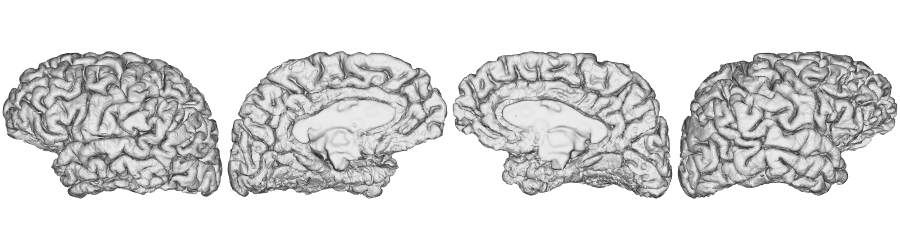

In [266]:
# Plot the surface
plot_hemispheres(surf_lh, surf_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

# FastSurfer | surface

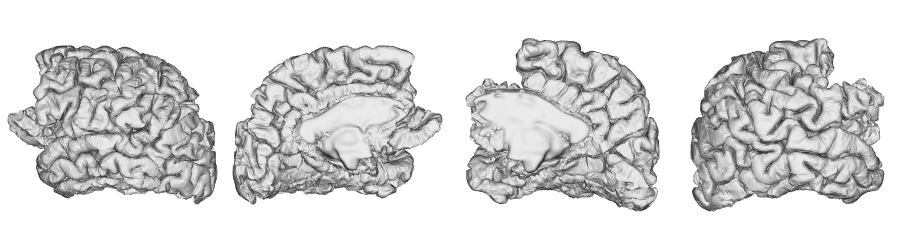

In [267]:
# Plot the surface
plot_hemispheres(surf_lhr, surf_rhr, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

In [268]:
print(surf_lh.points.shape[0])
print(surf_rh.points.shape[0])

print(surf_lhr.points.shape[0])
print(surf_rhr.points.shape[0])

201703
204161
89434
78753


# FreeSurfer | thickness

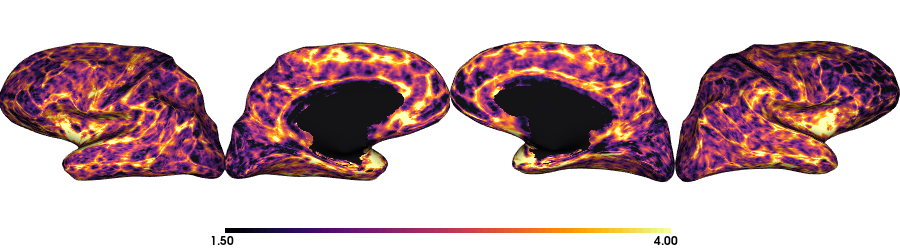

In [269]:
# Freesurfer native thickness
th = np.concatenate((nb.freesurfer.read_morph_data(dir_free + '/surf/lh.thickness'), nb.freesurfer.read_morph_data(dir_free + '/surf/rh.thickness')), axis=0)
plot_hemispheres(inf_lh, inf_rh, array_name=th, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap="inferno",transparent_bg=False)

# Fasturfer | thickness

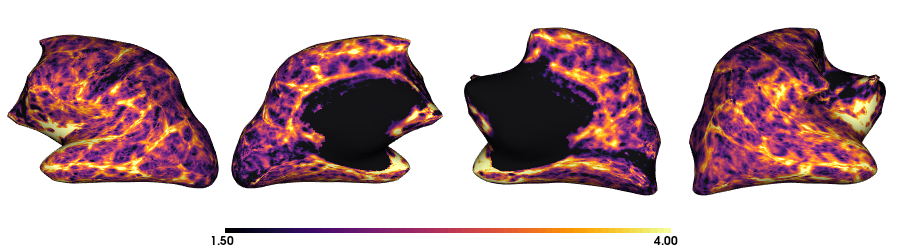

In [270]:
# Fastsurfer native thickness
thr = np.concatenate((nb.freesurfer.read_morph_data(dir_fast + '/surf/lh.thickness'), nb.freesurfer.read_morph_data(dir_fast + '/surf/rh.thickness')), axis=0)
plot_hemispheres(inf_lhr, inf_rhr, array_name=thr, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap="inferno",transparent_bg=False)

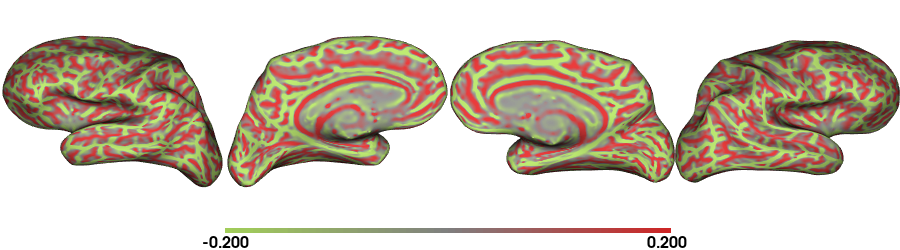

In [149]:
# Freesurfer native curvature
cv = np.concatenate((nb.freesurfer.read_morph_data(dir_free + '/surf/lh.curv'), nb.freesurfer.read_morph_data(dir_free + '/surf/rh.curv')), axis=0)
plot_hemispheres(inf_lh, inf_rh, array_name=cv, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap=ColCurv,transparent_bg=False)

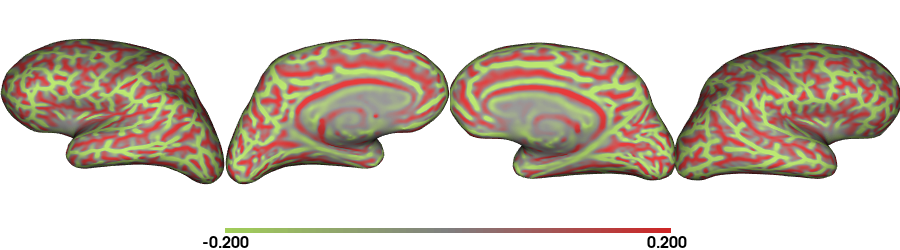

In [150]:
# Freesurfer native curvature
cv = np.concatenate((nb.freesurfer.read_morph_data(dir_fast + '/surf/lh.curv'), nb.freesurfer.read_morph_data(dir_fast + '/surf/rh.curv')), axis=0)
plot_hemispheres(inf_lhr, inf_rhr, array_name=cv, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap=ColCurv,transparent_bg=False)

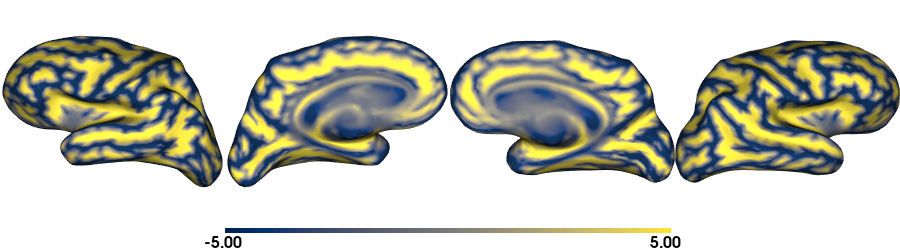

In [151]:
# Freesurfer native sulcal depth
sd = np.concatenate((nb.freesurfer.read_morph_data(dir_free + '/surf/lh.sulc'), nb.freesurfer.read_morph_data(dir_free + '/surf/rh.sulc')), axis=0)
plot_hemispheres(inf_lh, inf_rh, array_name=sd, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-5, 5), cmap='cividis',transparent_bg=False)

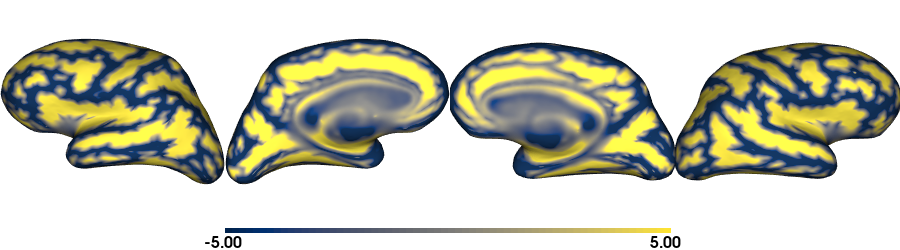

In [152]:
# Freesurfer native sulcal depth
sd = np.concatenate((nb.freesurfer.read_morph_data(dir_fast + '/surf/lh.sulc'), nb.freesurfer.read_morph_data(dir_fast + '/surf/rh.sulc')), axis=0)
plot_hemispheres(inf_lhr, inf_rhr, array_name=sd, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-5, 5), cmap='cividis',transparent_bg=False)

# Quantitative differences

In [271]:
# Set the working directory to the 'out' directory
os.chdir("/data_/mica3/BIDS_MICs/derivatives/free2fast")

def load_feature(feat, recon):
    
    # Load all the features
    th_lh_files=sorted(glob.glob('*_hemi-L_surf-fsaverage5_label-'+feat+'_'+recon+'.func.gii'))
    th_rh_files=sorted(glob.glob('*_hemi-R_surf-fsaverage5_label-'+feat+'_'+recon+'.func.gii'))

    # Load all the feat
    Nth=np.concatenate((nb.load(th_lh_files[0]).darrays[0].data, nb.load(th_rh_files[0]).darrays[0].data), axis=0).shape[0]

    th=np.empty([len(th_lh_files), Nth], dtype=float)
    for i, f in enumerate(th_lh_files):
        th[i,:] = np.hstack(np.concatenate((nb.load(th_lh_files[i]).darrays[0].data, nb.load(th_rh_files[i]).darrays[0].data), axis=0))
    return(th)

def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', vmin=None, vmax=None,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0):
    
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = mpl.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=vmin, vmax=vmax, xticklabels=xticklabels, yticklabels=yticklabels)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)
    # Rotate the x-axis labels
    # rotate tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xrot, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=yrot, ha='right')
    
def plot_rhos(corr_sim, bids_ids, feat):
    # extract the diagonal values
    diagonal = np.diag(corr_sim)

    # create a bar plot of the diagonal values
    mpl.bar(bids_ids, diagonal)

    # set the title and axis labels
    mpl.title('Similarity coefficient: '+feat)
    mpl.xlabel('')
    mpl.ylabel('Rho')

    # set the y-axis limits
    mpl.ylim(0.6, 1)

    # create horizontal lines on the background
    for i in np.arange(0.6, 1.1, 0.05):
        mpl.axhline(y=i, color='gray', alpha=0.5)

    # rotate the x labels by 90 degrees
    mpl.xticks(rotation=90)

    # remove the box line
    mpl.box(False)

    # show the plot
    mpl.show()

def feat_ttest(ft_free, ft_fast):
    # Concatenate all features
    ft = np.vstack((ft_free, ft_fast))
    df = pd.DataFrame({'group': ['free'] * ft_free.shape[0]  + ['fast'] * ft_fast.shape[0]})

    # Create a group variable
    term_grp = FixedEffect(df['group'])

    # contrast
    contrast_grp = (df.group == 'free').astype(int) - (df.group == 'fast').astype(int)

    # Model
    model = term_grp

    # fitting the model
    slm_model = SLM(
        model,
        contrast_grp,
        surf="fsaverage5",
        mask=fs5_mask,
        correction=["fdr", "rft"],
        cluster_threshold=0.01,
        two_tailed=True,
        )
    slm_model.fit(ft)
    return(slm_model)

# Thickness

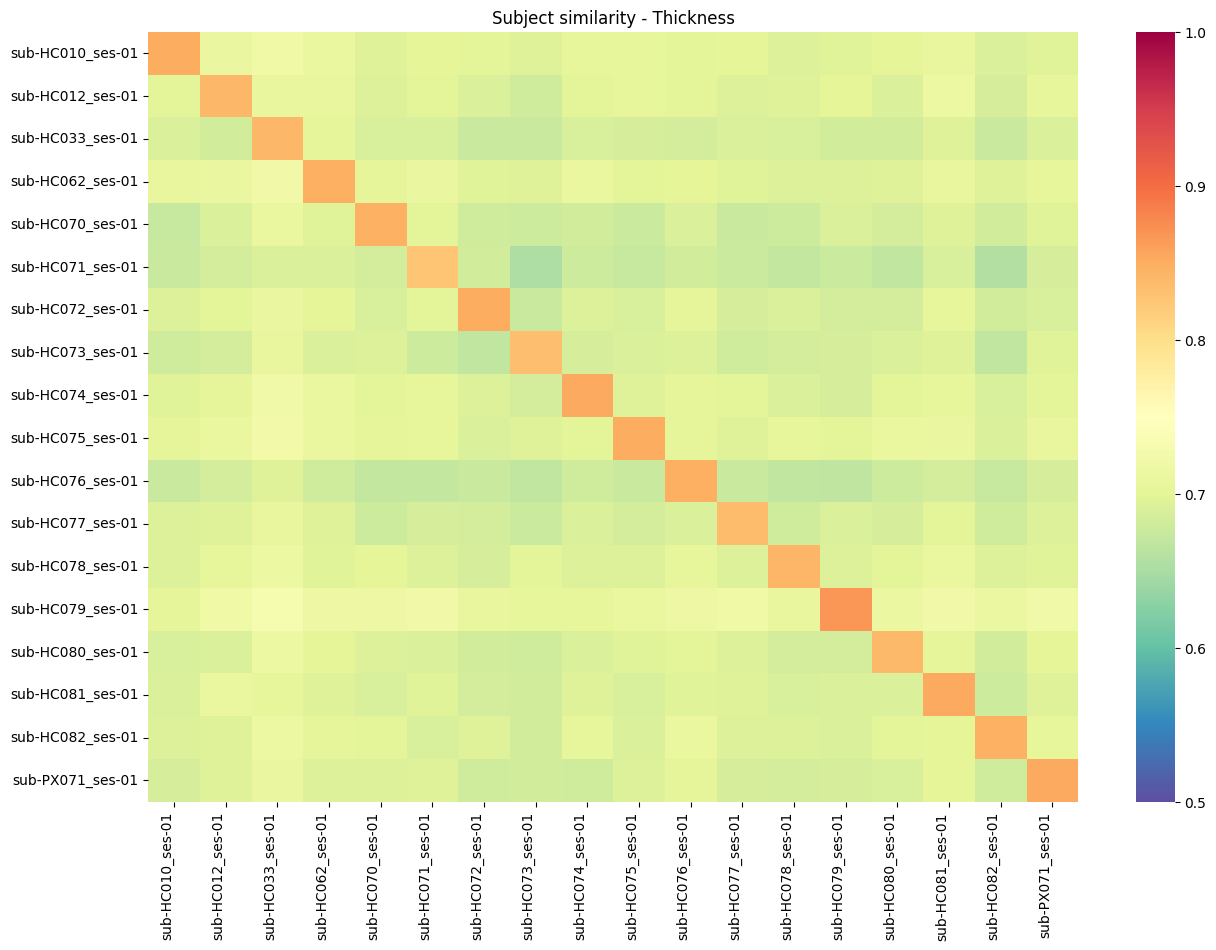

In [272]:
# subject list
sub_list=sorted(glob.glob('*_hemi-L_surf-fsaverage5_label-thickness_freesurfer.func.gii'))
bids_ids = [elem.split('_hemi-')[0] for elem in sub_list]

# load all the freesurfer thickness
th_free=load_feature('thickness', 'freesurfer')

# load all the fastsurfer thickness
th_fast=load_feature('thickness', 'fastsurfer')

# Similarity matrix
Nx=th_free.shape[0]
th_sim=np.corrcoef(th_free, th_fast)[0:Nx, Nx:Nx*2]

# 
plot_connectome(th_sim, 'Subject similarity - Thickness', xlab=None, ylab=None, col='Spectral_r', vmin=0.5, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


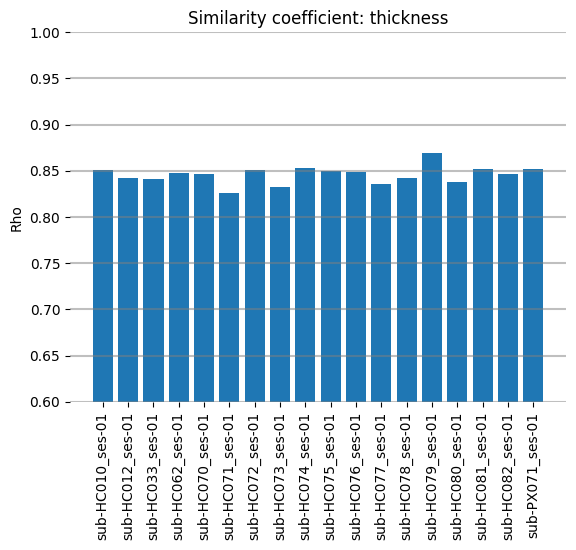

In [273]:
plot_rhos(th_sim, bids_ids, 'thickness')

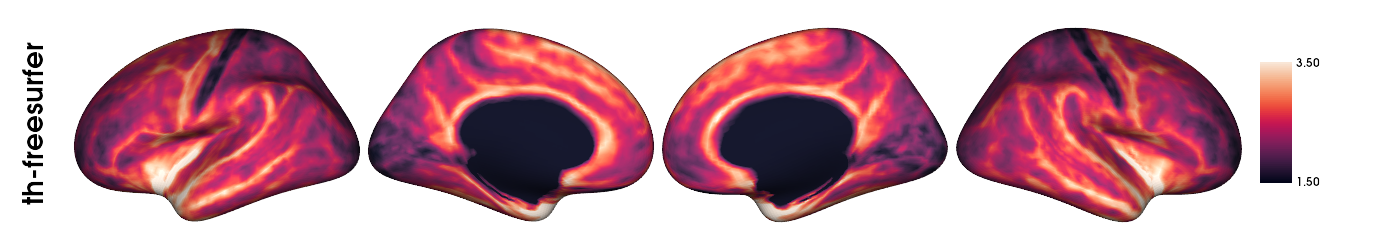

In [274]:
plot_hemispheres(fs5_lhi, fs5_rhi, np.mean(th_free, axis=0), color_bar=True, color_range=(1.5,3.5),
        label_text=["th-freesurfer"], cmap="rocket", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False)

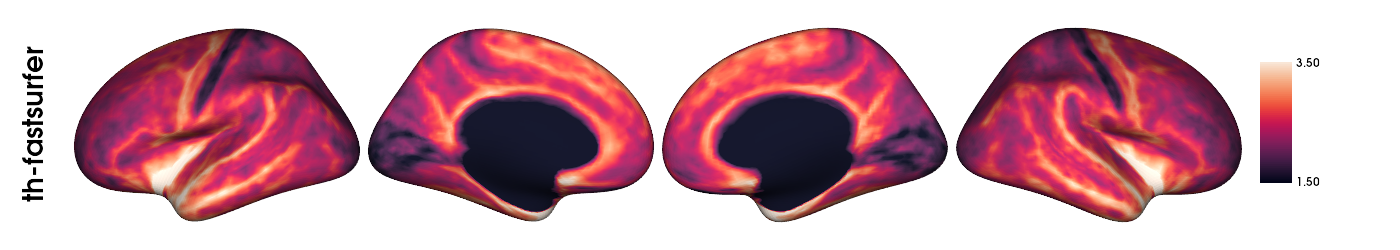

In [275]:
plot_hemispheres(fs5_lhi, fs5_rhi, np.mean(th_fast, axis=0), color_bar=True, color_range=(1.5,3.5),
        label_text=["th-fastsurfer"], cmap="rocket", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False)

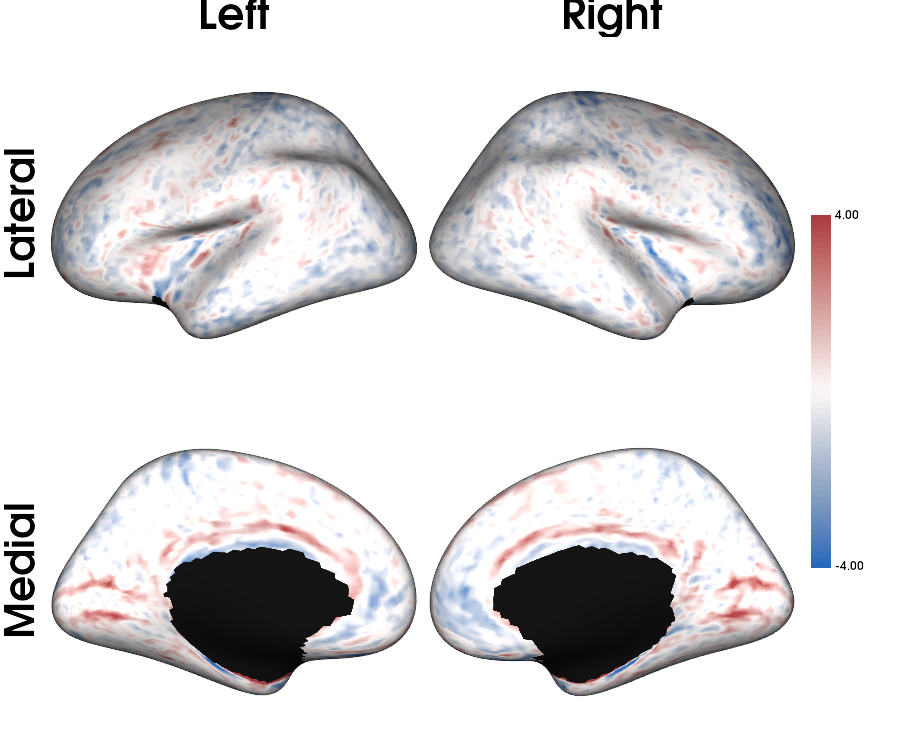

In [276]:
slm_model=feat_ttest(th_free, th_fast)
plot_hemispheres(fs5_lhi, fs5_rhi, slm_model.t, cmap='vlag', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(-4, 4),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']})

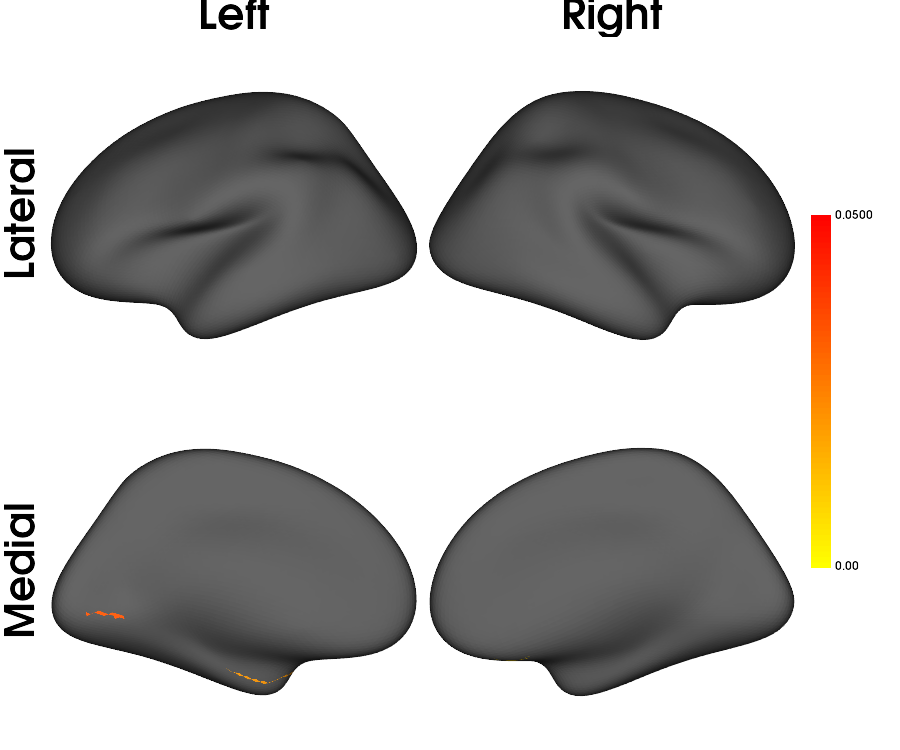

In [277]:
cp = [np.copy(slm_model.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~fs5_mask), np.nan) for x in cp]

plot_hemispheres(fs5_lhi, fs5_rhi, cp[0].T, cmap='autumn_r', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(0, 0.05),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']})

# Curvature

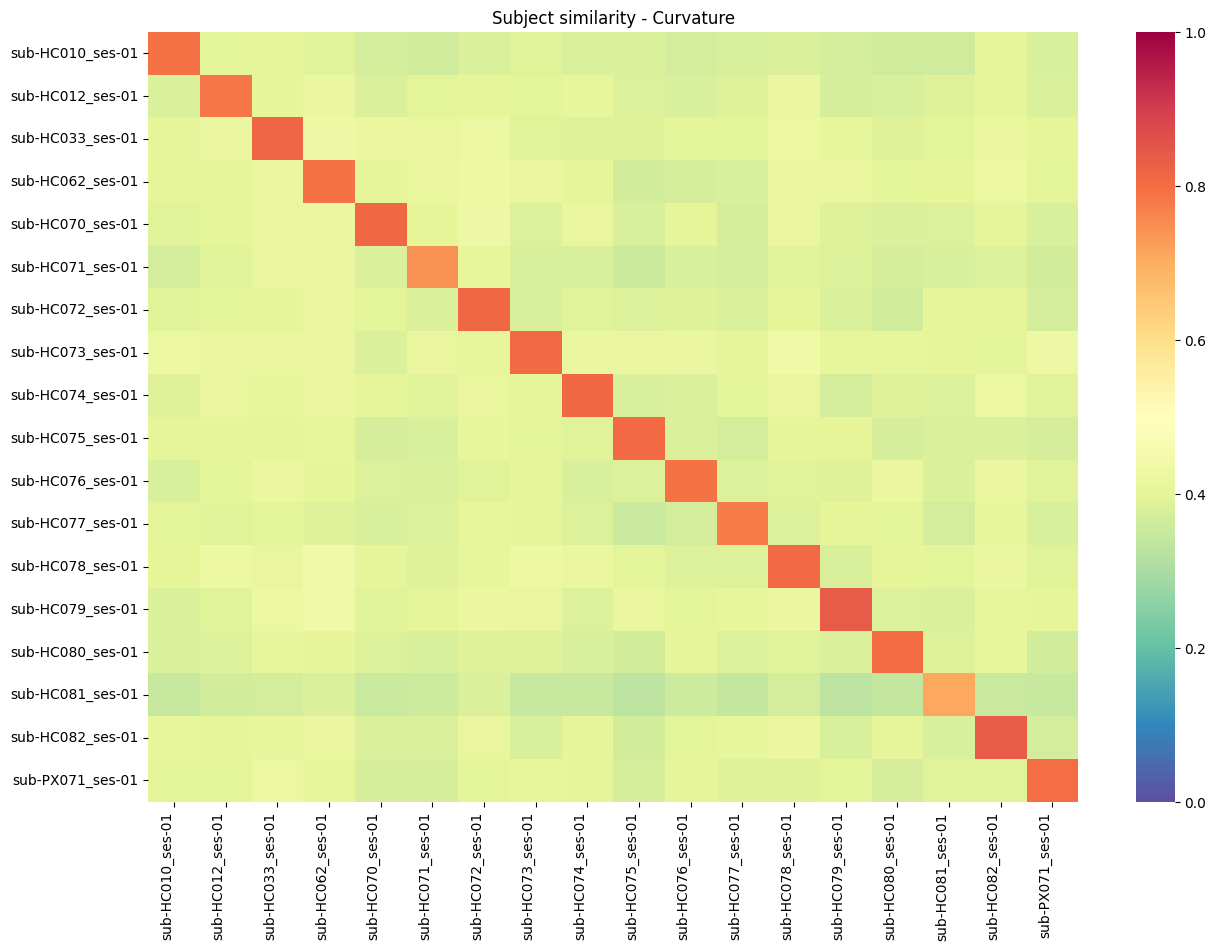

In [278]:
# load all the freesurfer thickness
cv_free=load_feature('curv', 'freesurfer')

# load all the fastsurfer thickness
cv_fast=load_feature('curv', 'fastsurfer')

# Similarity matrix
Nx=cv_free.shape[0]
cv_sim=np.corrcoef(cv_free, cv_fast)[0:Nx, Nx:Nx*2]

# Correlation matrix
plot_connectome(cv_sim, 'Subject similarity - Curvature', xlab=None, ylab=None, col='Spectral_r', vmin=0, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


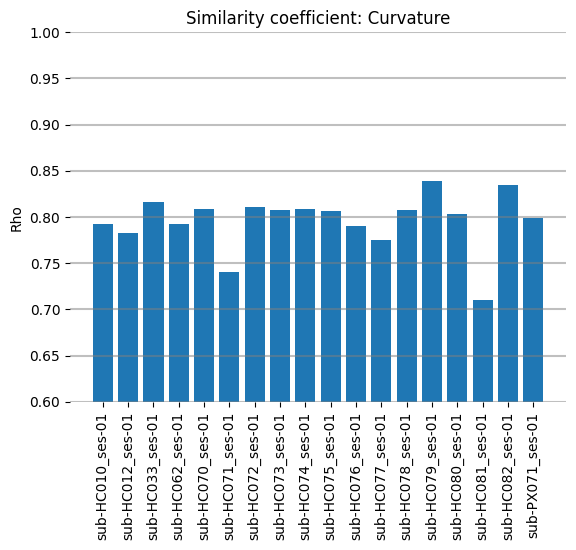

In [279]:
plot_rhos(cv_sim, bids_ids, 'Curvature')

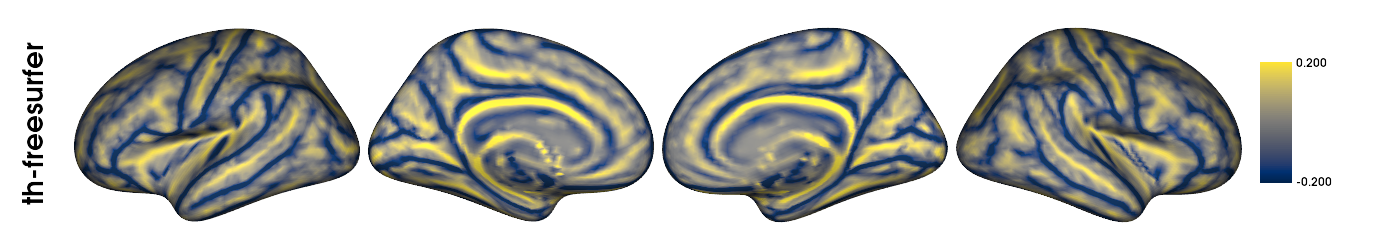

In [280]:
plot_hemispheres(fs5_lhi, fs5_rhi, np.mean(cv_free, axis=0), color_bar=True, color_range=(-0.2,0.2),
        label_text=["th-freesurfer"], cmap="cividis", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False)

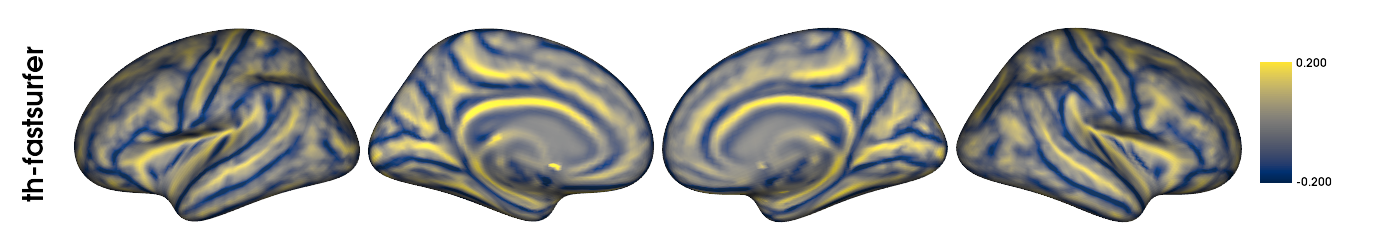

In [281]:
plot_hemispheres(fs5_lhi, fs5_rhi, np.mean(cv_fast, axis=0), color_bar=True, color_range=(-0.2,0.2),
        label_text=["th-fastsurfer"], cmap="cividis", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False)

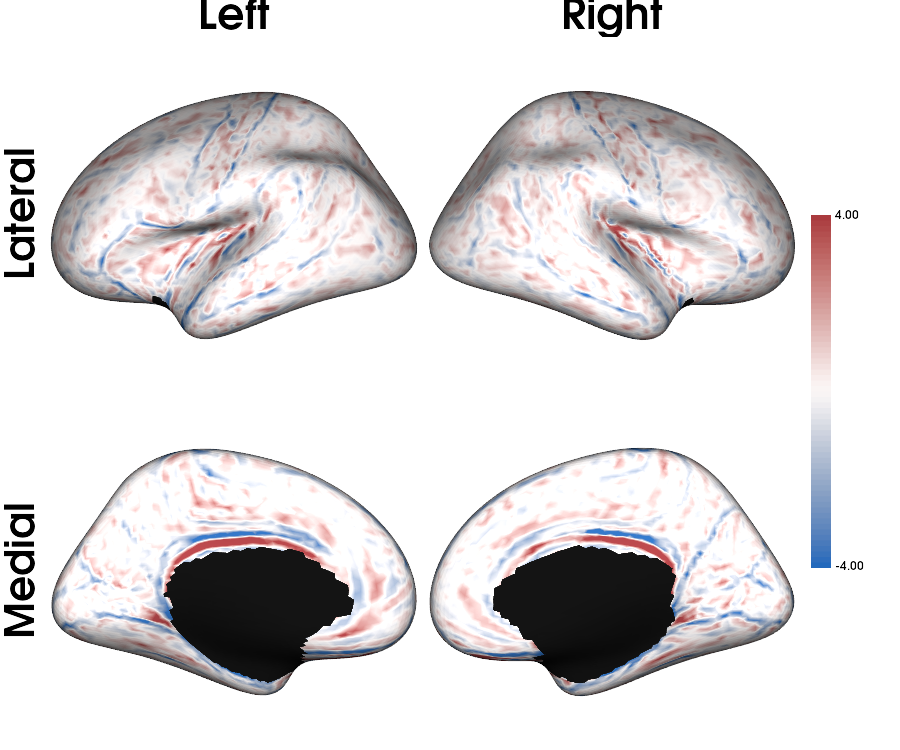

In [282]:
slm_model=feat_ttest(cv_free, cv_fast)
plot_hemispheres(fs5_lhi, fs5_rhi, slm_model.t, cmap='vlag', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(-4, 4),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']})

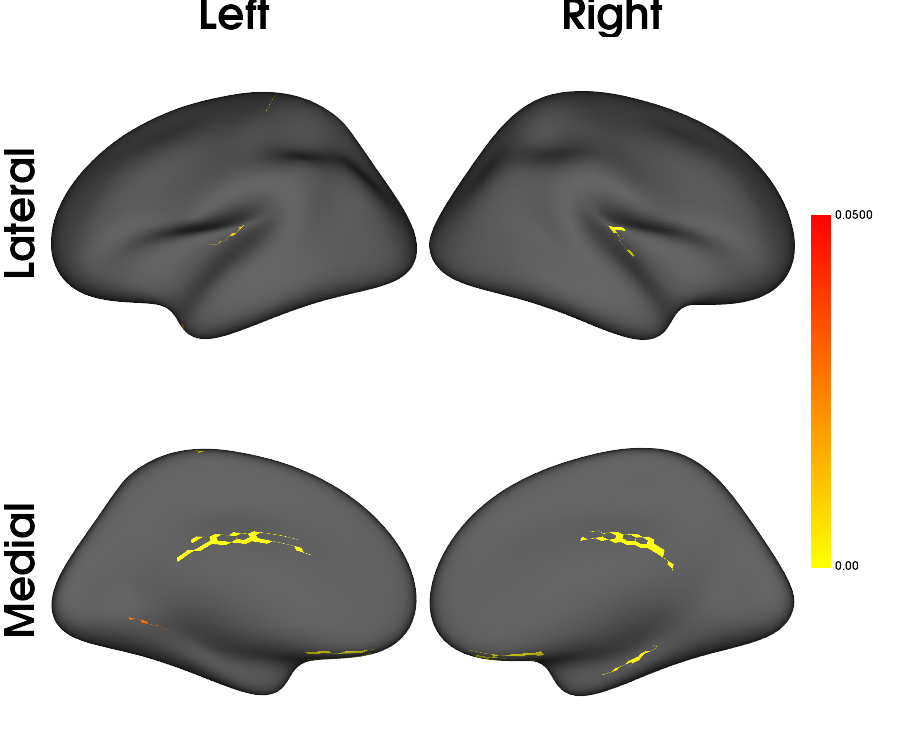

In [283]:
cp = [np.copy(slm_model.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~fs5_mask), np.nan) for x in cp]

plot_hemispheres(fs5_lhi, fs5_rhi, cp[0].T, cmap='autumn_r', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(0, 0.05),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']})

# Sulcal deep

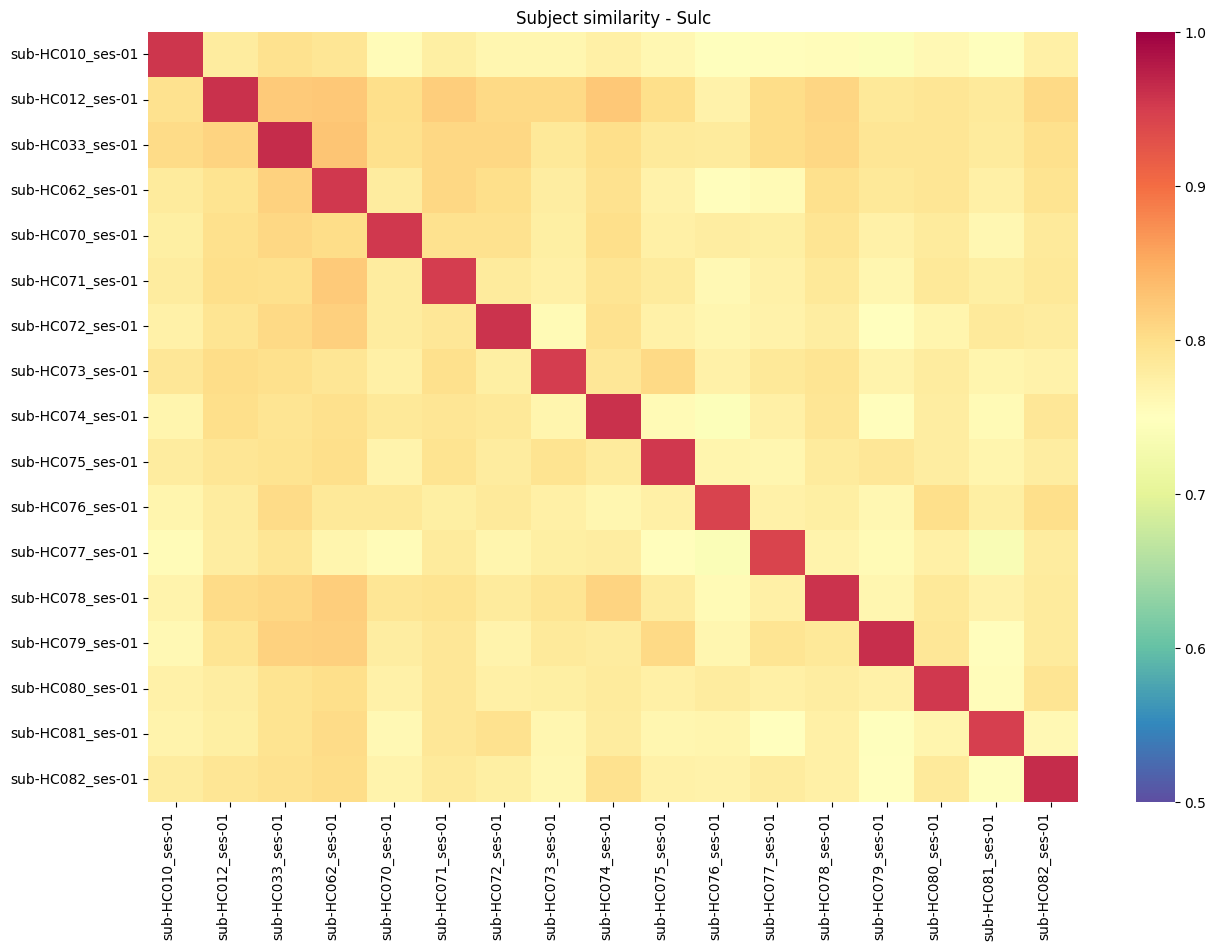

In [284]:
# subject list
sub_list=sorted(glob.glob('*_hemi-L_surf-fsaverage5_label-sulc_freesurfer.func.gii'))
bids_ids = [elem.split('_hemi-')[0] for elem in sub_list]

# load all the freesurfer thickness
sd_free=load_feature('sulc', 'freesurfer')

# load all the fastsurfer thickness
sd_fast=load_feature('sulc', 'fastsurfer')

# Similarity matrix
Nx=sd_free.shape[0]
sd_sim=np.corrcoef(sd_free, sd_fast)[0:Nx, Nx:Nx*2]

# Correlation matrix
plot_connectome(sd_sim, 'Subject similarity - Sulc', xlab=None, ylab=None, col='Spectral_r', vmin=0.5, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


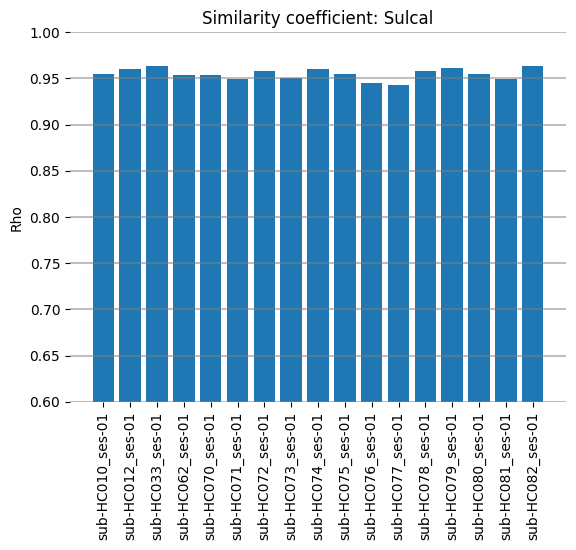

In [285]:
plot_rhos(sd_sim, bids_ids, 'Sulcal')

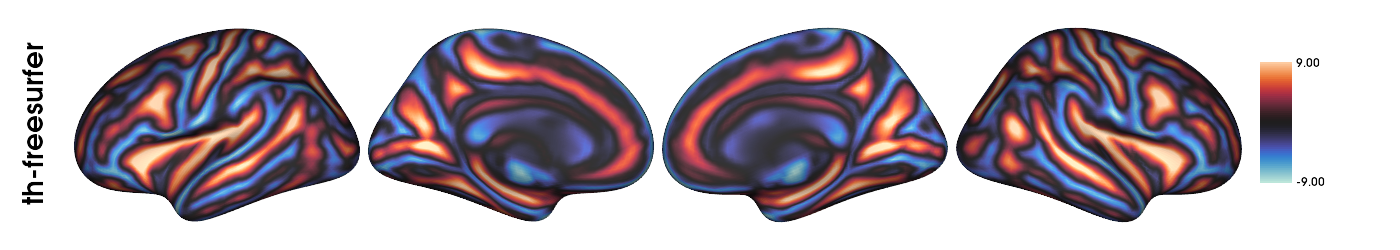

In [286]:
plot_hemispheres(fs5_lhi, fs5_rhi, np.mean(sd_free, axis=0), color_bar=True, color_range=(-9,9),
        label_text=["th-freesurfer"], cmap="icefire", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False)

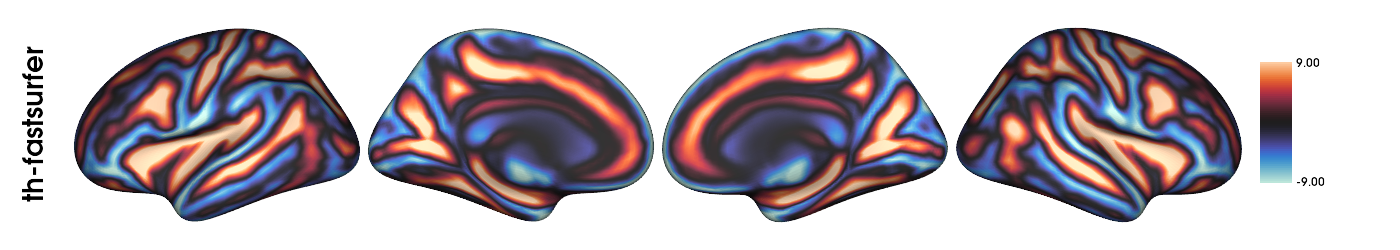

In [287]:
plot_hemispheres(fs5_lhi, fs5_rhi, np.mean(sd_fast, axis=0), color_bar=True, color_range=(-9,9),
        label_text=["th-fastsurfer"], cmap="icefire", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False)

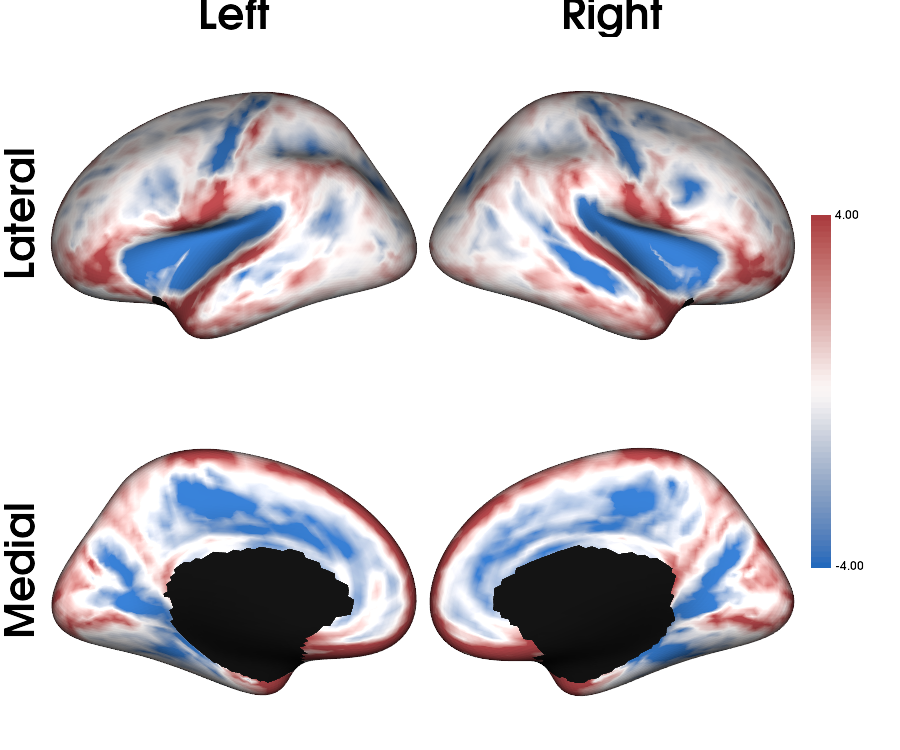

In [288]:
slm_model=feat_ttest(sd_free, sd_fast)
plot_hemispheres(fs5_lhi, fs5_rhi, slm_model.t, cmap='vlag', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(-4, 4),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']})

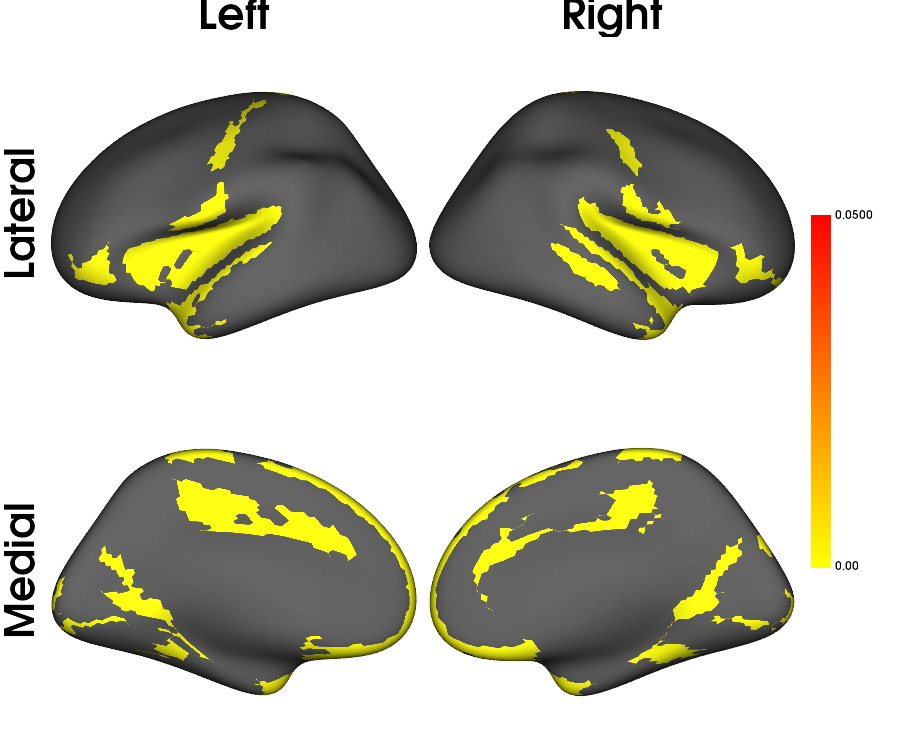

In [289]:
cp = [np.copy(slm_model.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~fs5_mask), np.nan) for x in cp]

plot_hemispheres(fs5_lhi, fs5_rhi, cp[0].T, cmap='autumn_r', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(0, 0.05),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']})

# Cortical effects HC vs PX: `freesurfer`

# Cortical effects HC vs PX: `fastsurfer`